# Spectrograms and Regime Change Detection

In this example we show how Koopman theory can be used to analyze the behaviour of a switching system, validating our results with Fourier theory. We study a simple signal composed by a sum of a small number of sinusoidal functions. These signals are easily analyzed using Fourier theory, but similar results can be obtained via Koopman theory and its implementation in `kooplearn`. In particular, we show that how to recover changes in the signal by detecting changes in the underlying process. Here, this will be modeled by a sudden change of the dominant frequencies of the signal during a _switching_ period.

## Data generation 

In [1]:
# Standard imports
import numpy as np
from tqdm.notebook import tqdm

np.random.seed(0)

import matplotlib.pyplot as plt

We now generate a synthetic signal for our analysis. Our dataset will have $10000$ points of the signal's trajectory, all observed at a regular interval of one $0.01 \, {\rm s}$. We also set that between $t = 4000$ and $t = 4500$ it occurs a ragime change in which the dominant frequencies of the signal change.

In [2]:
N = 10000 # Trajectory steps
start_regime_change = 4000
end_regime_change = 4500

In the following we define a function that given an input array `i` representing time and a list of frequencies `freqs` returns the signal observed at each time step.

In [3]:
def gen_signal(i, freqs):
    X = np.zeros(i.shape[0])
    for f in freqs:
        X += np.sin(i*f*2*np.pi)
    return X

We can now create our signal. The signal in the first regime has frequencies 2Hz, 8Hz, 13Hz and 15Hz. The signal in the second regime has frequencies 5Hz and 7Hz.

In [4]:
i = np.arange(N)/100

# REGIME 1
X1 = gen_signal(i, [2, 8, 13, 15])
    
# REGIME 2
X2 = gen_signal(i, [5, 7])

# Mixing the regimes
X_no_noise = np.concatenate([X1[:start_regime_change], 
                    X2[start_regime_change:end_regime_change],
                    X1[end_regime_change:]])

The signal is then perturbed by an additive noise with a small variance compared to the values taken by the signal.

In [5]:
noise = 0.2*np.random.randn(N)

X = X_no_noise + noise

Let us plot the trajectories of our dataset:

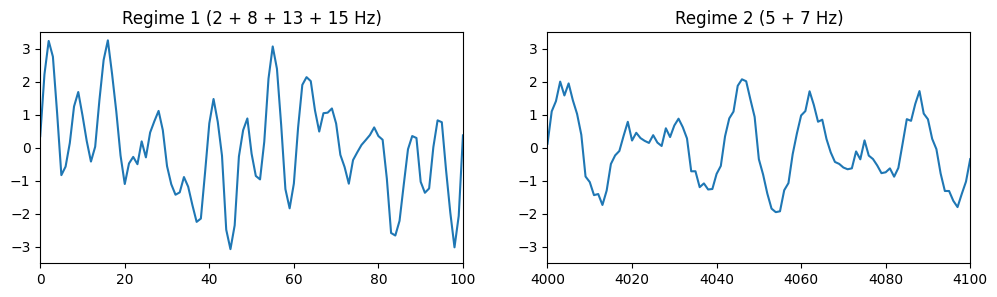

In [6]:
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.plot(X[:101])
plt.ylim((-3.5, 3.5))
plt.margins(x = 0)
plt.title('Regime 1 (2 + 8 + 13 + 15 Hz)')

plt.subplot(1, 2, 2)
plt.plot(np.arange(4000, 4101), X[4000:4101])
plt.ylim((-3.5, 3.5))
plt.title('Regime 2 (5 + 7 Hz)')
plt.margins(x = 0)
plt.show()

Let us verify that we do recover those frequencies using the classical Fourier spectrogram as implemented in `scipy.signal``.

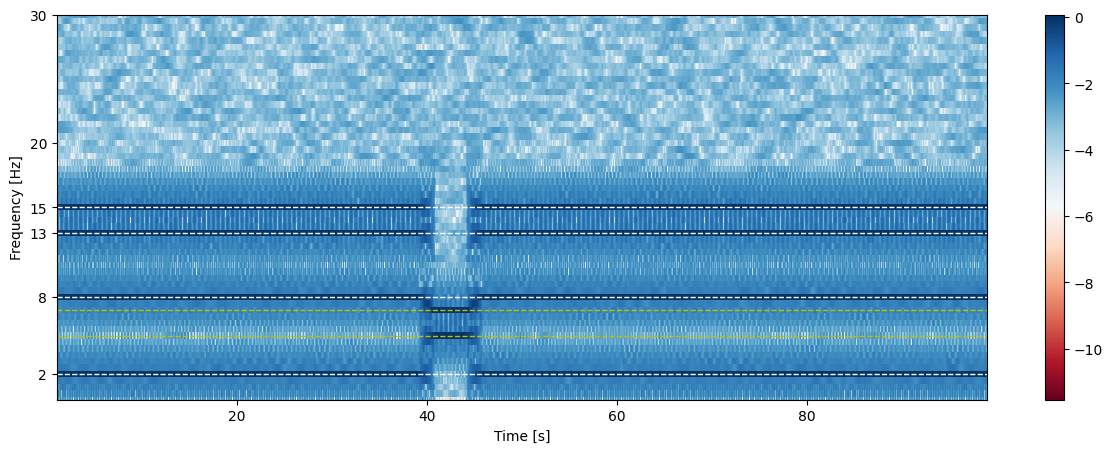

In [7]:
from scipy import signal

n_seg = 200
f, t, Sxx = signal.spectrogram(X, 100, scaling='density', nperseg=n_seg, noverlap=199)
plt.figure(figsize=(15,5))
plt.grid(False)
plt.pcolormesh(t, f, np.log10(Sxx), cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks([2, 8, 13, 15, 20, 30, 40, 50])
plt.ylim(0, 30)
plt.axhline(y=2, color='w', linestyle='--', lw=1)
plt.axhline(y=8, color='w', linestyle='--', lw=1)
plt.axhline(y=13, color='w', linestyle='--', lw=1)
plt.axhline(y=15, color='w', linestyle='--', lw=1)
plt.axhline(y=5, color='y', linestyle='--', lw=1)
plt.axhline(y=7, color='y', linestyle='--', lw=1)
plt.colorbar()
plt.show()

## Koopman model

We now show that fitting a Koopman operator enables a complete characterization of the dynamics. The first step to fit a Koopman model with kooplearn is to organize the data according to the [paradigm based on context windows](kooplearn_data_paradigm). Since in this case we have a single trajectory we can use the utility function {meth}`kooplearn.data.traj_to_contexts`. We set the context size to $200$, matching our choice for the Fourier spectrogram.

In [8]:
from kooplearn.data import traj_to_contexts

dataset = traj_to_contexts(X, context_window_len = 100)

n_pts, ctx_len, _ = dataset.shape
print(f"Dataset has {n_pts} context windows of size {ctx_len}.")

Dataset has 9901 context windows of size 100.


We now take a small subset of the full dataset and fit a Koopman model on it. For this example we will use kernel methods, and specifically the _Reduced Rank Regression_ described in {footcite:t}`Kostic2022`. We use a combination of linear and Gaussian (i.e. RBF) kernels, the latter of which with a length-scale corresponding to the median heuristic.

In [9]:
from sklearn.gaussian_process.kernels import DotProduct, RBF
from kooplearn.models.kernel import KernelDMD
from scipy.spatial.distance import pdist

train_contexts = dataset[:500]

median_heuristic_lengthscale = np.median(pdist(X.reshape(-1, 1)))
kernel = 0.5*(DotProduct() + RBF(length_scale=median_heuristic_lengthscale))
model = KernelDMD(reduced_rank= True, kernel=kernel, rank=8, tikhonov_reg=1e-5)
model.fit(train_contexts);

Fitted KernelDMD model. Lookback length set to 99


The dominant frequencies of the dynamics $\omega_{i}$ are related to the Koopman eigenvalues $\lambda_{i}$ by the relation $\omega_{i} = \frac{1}{2\pi \Delta t}\deg (\lambda_{i})$, with $\Delta t$ being the time lag between samples. By evaluating `model.eig()` we can see that the Koopman model perfectly recover the frequencies of the signal:

In [10]:
dominant_frequencies = 100*np.angle(model.eig())/(2*np.pi)
for f in dominant_frequencies:
    if f > 0: # Koopman eigenvalues come in complex-conjugate paris. Discarting the eigenvalues with negative imaginary part.
        print(f"Found {f:.3f} Hz as a dominant freqency of the dynamics")

Found 15.003 Hz as a dominant freqency of the dynamics
Found 13.000 Hz as a dominant freqency of the dynamics
Found 8.000 Hz as a dominant freqency of the dynamics
Found 2.000 Hz as a dominant freqency of the dynamics


The Koopman model can be used also to forecast the signal (and any observable of it). By taking a validation subset of the full data, we can verify that the forecast is very accurate as well.

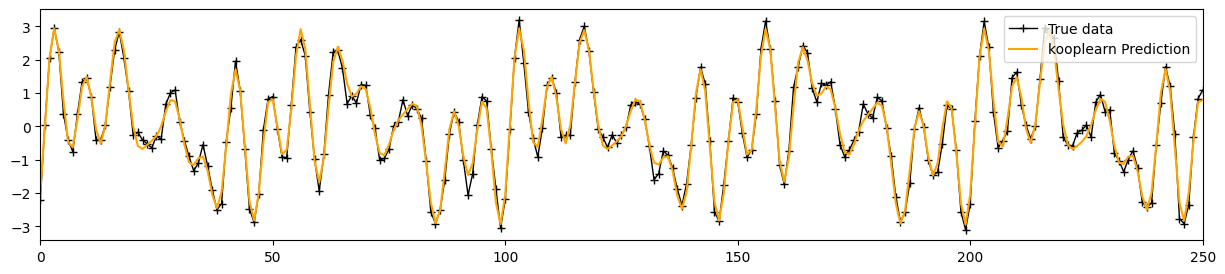

In [11]:
val_contexts = dataset[5000:5251]

plt.figure(figsize=(15,3))
X_pred = np.squeeze([model.predict(val_contexts[:1, :model.lookback_len, ...], t = t) for t in range(1, len(val_contexts) + 1)])
X_true = np.squeeze(val_contexts[:, model.lookback_len:, ...])

plt.plot(X_true, '+-', label='True data', lw=1, color='k')
plt.plot(X_pred, label='kooplearn Prediction', color='orange')
plt.margins(x=0)
plt.legend()
plt.show()

## [TO FINISH - Sync Spectrogram code] Koopman spectral decomposition and spectrogram

Now that we have selected a good kernel, we can now use it to train koopman operators on subsets of the dataset and examine their modes.

DESCR OF ALGO



In [12]:
from kooplearn.signal.analysis import spectrogram

# Parameters of the spectrogram
N = 100        # Number of samples (of states) for each training round
steps = 10     # Step size between two training (speed of the moving window)
T=100          # Number of time steps composing each state

# Defining the lambda
observable = lambda x : x[:,0]

Now, let us see train our models and save their results in a pickle file.

In [13]:
# Drawing the spectrogram
freqs, phases, amplitudes, modulus = spectrogram(X, model, N, steps, T, observable, deltat=0.01)

100%|██████████| 970/970 [00:17<00:00, 55.29it/s]


Let us plot the resulting spectrogram.

  0%|          | 0/97 [00:00<?, ?it/s]

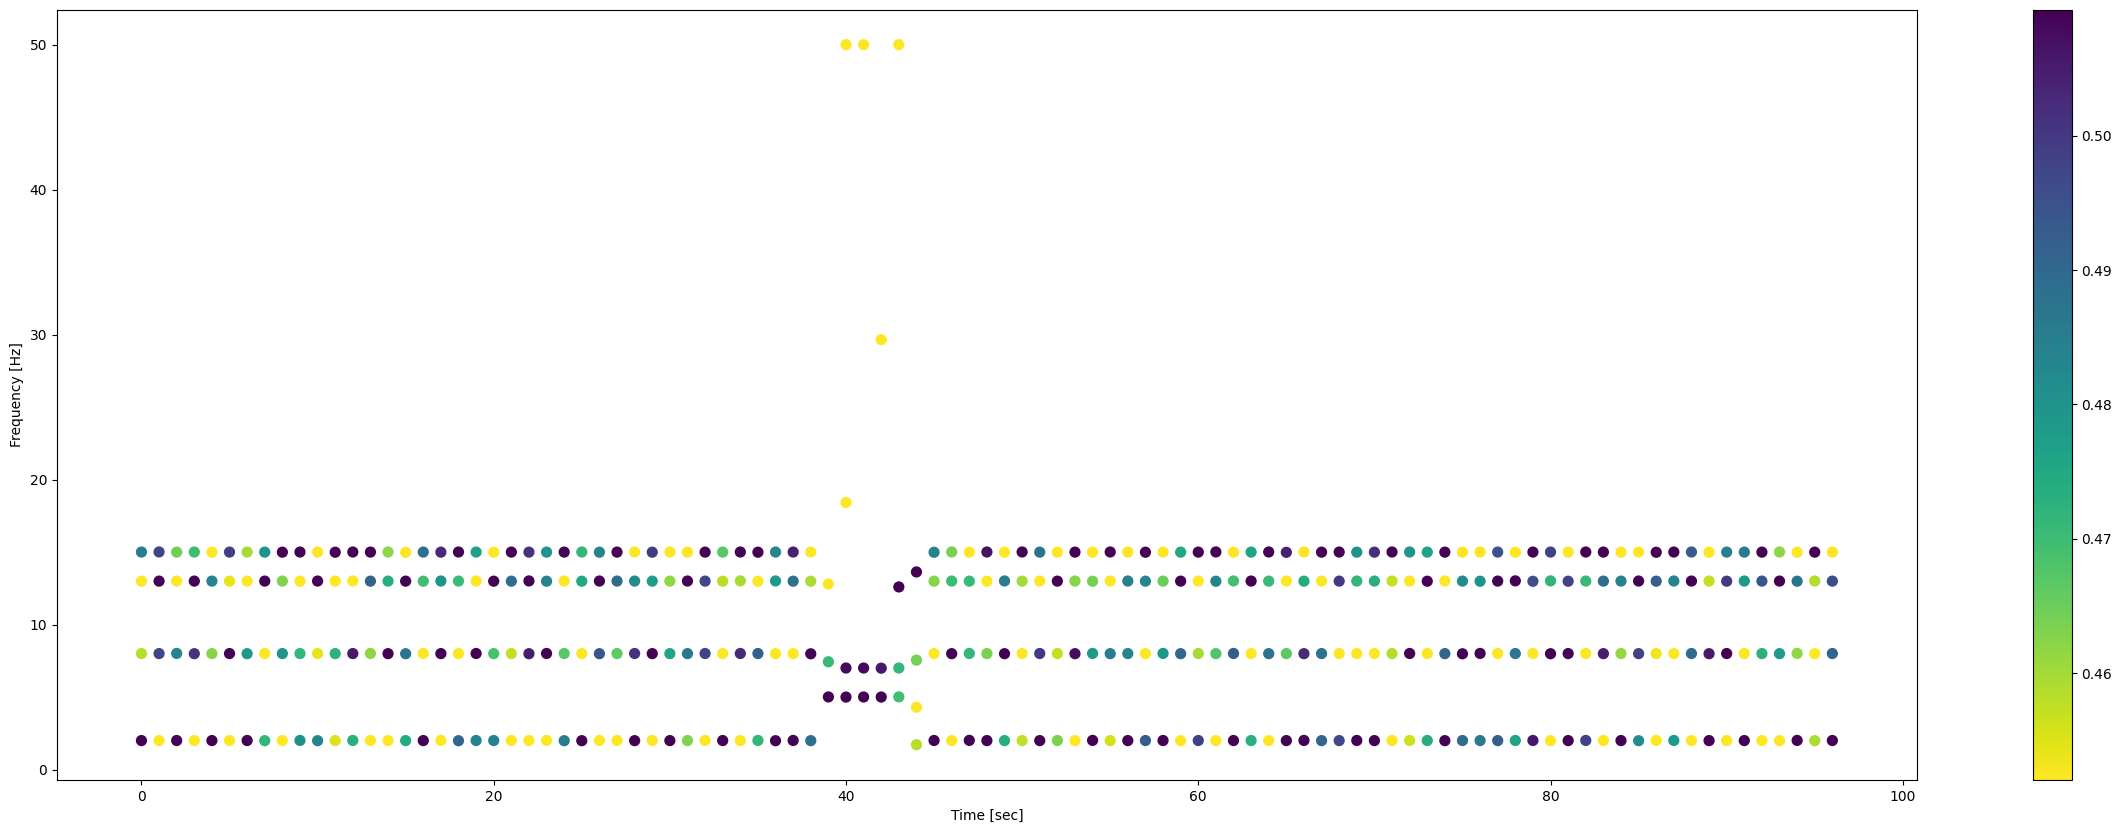

In [14]:
# Plotting the spectrogram
plt.figure(figsize=(30,10))
amplitudes[freqs <= 0] = np.nan                          # dropping values for negative freqs
secs = np.arange(freqs.shape[0])/10                      # X axis in seconds
xs = np.outer(secs, np.ones(freqs.shape[1]))             # reformatting for plt scatter
for i in tqdm(range(0, xs.shape[0], 10)):
    plt.scatter(x=xs[i], y=freqs[i], c=amplitudes[i], cmap='viridis_r', s=50)
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

As a reference, here is the Fourier spectrogram from earlier:

In [ ]:
plt.figure(figsize=(15,5))
plt.grid(False)
plt.pcolormesh(t, f, np.log10(Sxx), cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks([2, 8, 13, 15, 20, 30, 40, 50])
plt.ylim(0, 30)
plt.axhline(y=2, color='w', linestyle='--', lw=1)
plt.axhline(y=8, color='w', linestyle='--', lw=1)
plt.axhline(y=13, color='w', linestyle='--', lw=1)
plt.axhline(y=15, color='w', linestyle='--', lw=1)
plt.axhline(y=5, color='y', linestyle='--', lw=1)
plt.axhline(y=7, color='y', linestyle='--', lw=1)
plt.colorbar()
plt.show()

The two plots clearly identified the relevant frequencies. In the following section, we will show that the frequencies selected by Koopman theory can be used to cluster the timesteps to automatically distinguish the two regimes.

## [TO FINISH] Regime change detection

Now that we have computed the spectrogram of the entire series, let us see how we can use the selected frequencies for detecting regime changes. First, let us load the spectrogram's information.

In [ ]:
# sorting frequencies
freqs.sort(axis=-1)

And now with DBSCAN:

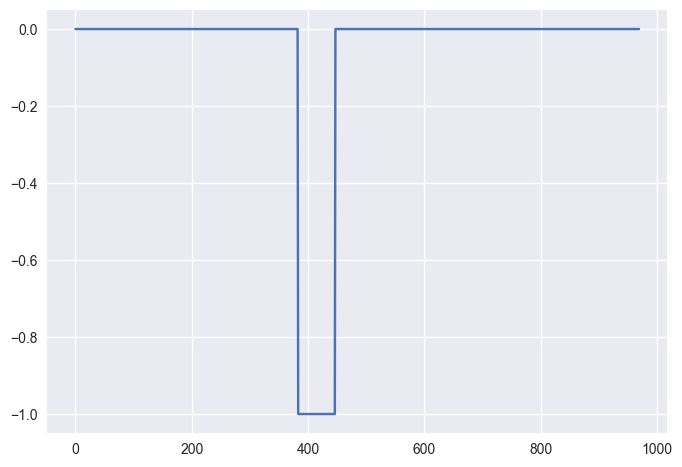

In [ ]:
from sklearn.cluster import DBSCAN
cls = DBSCAN(eps=0.1)
classes = cls.fit_predict(freqs)
plt.plot(classes)